In [213]:
import numpy as np
import random
import math
import matplotlib.pyplot as plt
from matplotlib import cm
import collections
import functools
from IPython import display
import itertools
from time import sleep

# Model Cancer spread with intervention
Four Effective States - Normal(1), Cancer(2), Reproducing_Cancer(3), Dead(4), Empty(0)
Assumptions: 
 1) Normal Cells turn to Cancer due to mutation every t_NC steps.\
 2) Normal Cells do not reproduce.\
 3) All Cells die at same rate.\
 4) Cancer Cells turn Reproducing_Cancer after n steps.\
 5) Reproducing Cancer reproduce to Cancer with every m steps to k neighbor cells\
 7) Dead cells get removed from grid every l steps\
 8) Moore neighborhood assumed. New RC cells replace live cells.\
 9) Boundary Condition is fixed.\
 10) Intervention is a removal of cells lie on a subsquare(n,n)\


In [231]:
# helper functions
def get_left(position,r):
    i,j = position
    return [i-r, j]

def get_right(position,r):
    i,j = position
    return [i+r, j]

def get_top(position, r):
    i,j = position
    return [i, j+r]

def get_bottom(position, r):
    i,j = position
    return [i, j-r]

def get_top_right(position, r):
    i,j = position
    return [i+r, j+r]

def get_top_left(position, r):
    i,j = position
    return [i-r, j+r]

def get_bottom_right(position,r):
    i,j = position
    return [i+r,j-r]

def get_bottom_left(position,r):
    i,j = position
    return [i-r,j-r]

def check_valid_rates(cancer_reproduction, death_rate, conversion_rates, dead_cell_removal_rate, num_steps):
    # some assumptions
    assert cancer_reproduction["period"] > 0
    assert cancer_reproduction["num_cells"] > 0
    assert cancer_reproduction["num_cells"] < 8
    assert conversion_rates["N_to_C"] > 0
    assert conversion_rates["C_to_RC"] > 0
    assert death_rate > 0
    assert dead_cell_removal_rate > 0   
    
def observe(config):
    plt.cla()
    plt.imshow(config, vmin = 0, vmax = 1)

In [232]:
# l1 = [i for i in range(10)]
# l2 = [i for i in range(10)]
# grid_positions = list(itertools.product(l1, l2))
# print(grid_positions)

In [297]:
class CA:
    def __init__(self, x, cancer_reproduction, death_rate, conversion_rates, dead_cell_removal_rate):
        self.grid = np.zeros((x,x),dtype = int)
        self.history = []
        self.x = x # grid size
        self.cancer_reproduction= {"period": cancer_reproduction["period"],
                                  "num_cells":cancer_reproduction["num_cells"]}
        self.death_rate = death_rate
        self.conversion_rates = {"N_to_C": conversion_rates["N_to_C"],
                                 "C_to_RC": conversion_rates["C_to_RC"]}
        self.dead_cell_removal_rate = dead_cell_removal_rate
        self.num_steps = 0
        
        
    def initialize_grid(self, num_steps):
        self.grid[:][:] = 1 # all Normal Cells
        self.num_steps = num_steps
        
    def get_grid_positions(self):
        l1 = [i for i in range(self.x)]
        l2 = [i for i in range(self.x)]
        return list(itertools.product(l1, l2))
    
    # fixed boundary condition
    def get_moore_neighbours(self, grid_position):
        positions = []
        i,j = grid_position
        max_dim = len(self.grid) - 1
        r = 1
        if i > 0 and i < max_dim and j > 0 and j < max_dim:
            positions = [get_top(grid_position, r),get_bottom(grid_position,r),
                         get_left(grid_position,r),get_right(grid_position,r),
                        get_top_right(grid_position,r), get_top_left(grid_position,r),
                        get_bottom_right(grid_position,r), get_bottom_left(grid_position,r)]
        elif i == 0 and j == 0: 
            positions = [get_top(grid_position, r), get_right(grid_position,r),
                        get_top_right(grid_position,r)]
        elif i == 0 and (j > 0 and j < max_dim): 
            positions = [get_bottom(grid_position, r), get_right(grid_position,r),get_bottom_right(grid_position,r),
                        get_top(grid_position, r), get_top_right(grid_position,r)]
        elif i == 0 and j == max_dim:
            positions = [get_bottom(grid_position, r), get_bottom_right(grid_position,r),
                        get_right(grid_position,r)]
        elif (i > 0 and i < max_dim) and j == 0:
            positions = [get_top(grid_position, r), get_left(grid_position,r),
                        get_top_left(grid_position,r), get_right(grid_position,r), get_top_right(grid_position,r)]
        elif i == max_dim and j == 0:
            positions = [get_top(grid_position, r), get_left(grid_position,r), get_top_left(grid_position,r)]
        else: # (max_dim, max_dim)
            positions = [get_bottom(grid_position, r), get_left(grid_position,r), get_bottom_left(grid_position,r)]
            
        return positions
    
    def print_params(self):
        print("Cancer reproduction n_Cells = "+str(self.cancer_reproduction["num_cells"]))
        print("Cancer reproduction period = "+str(self.cancer_reproduction["period"]))
        print("Death rate = "+str(self.death_rate))
        print("Conversion rates Normal to Cancer = "+str(self.conversion_rates["N_to_C"]))
        print("Conversion rates Cancer to Reproducing Cancer = "+str(self.conversion_rates["C_to_RC"]))
        print("Dead Cells removal rate = "+str(self.dead_cell_removal_rate))
        
    def update(self, step):
        if step <= self.num_steps:
            for position in self.get_grid_positions():
                # update alive cells
                if self.grid[position[0]][position[1]] == 1:  
                    if (step % self.conversion_rates["N_to_C"] == 0):
                        die = random.uniform(0,1)
                        if (die < 0.1):
                            self.grid[position[0]][position[1]] = 2 # Turn to Cancer cells.
                # update cancer cells
                elif self.grid[position[0]][position[1]] == 2:
                    # check current time step == reproductive cancer conversion rate
                    if (step % self.conversion_rates["C_to_RC"] == 0):
                        self.grid[position[0]][position[1]] = 3 # Turn to Reproductive Cancer cells
                    if (step % self.death_rate == 0):
                        self.grid[position[0]][position[1]] = 4 # Turn to Dead cells
                # update_ reproductive_cancer_ce lls
                elif self.grid[position[0]][position[1]] == 3:
                    # check current time step == period of cancer reproduction
                    if (step % self.cancer_reproduction["period"] == 0):
                        neighbors = self.get_moore_neighbours(position)
                        converted_neighbors = random.sample(neighbors, self.cancer_reproduction["num_cells"])
                        for neighbor in converted_neighbors:
                            self.grid[neighbor[0]][neighbor[1]] = 3
                    if (step % self.death_rate == 0):
                        self.grid[position[0]][position[1]] = 4 # Turn to Dead cells
                # update dead cells   
                elif self.grid[position[0]][position[1]] == 4:
                    # check current time step == dead_removal_rate
                    if (step % self.death_rate == 0):
                        self.grid[position[0]][position[1]] = 0
                
                                 
        return self.grid
                
    def print_grid(self):
        print(self.grid)

In [298]:
def observe(grid):
        plt.cla()
        plt.imshow(grid, vmin = 0, vmax = 4)
#         plt.show()


In [312]:
# Setup Parameters
cancer_reproduction = {"period": 20,
                       "num_cells": 1}
death_rate = 50
conversion_rates = {"N_to_C": 10,
                    "C_to_RC": 20}
dead_cell_removal_rate = 150

num_steps = 500
check_valid_rates(cancer_reproduction,death_rate, conversion_rates, dead_cell_removal_rate, num_steps)
grid_size = 10

In [313]:
# # Test moore neighbors
ca_test = CA(grid_size, cancer_reproduction, death_rate, conversion_rates, dead_cell_removal_rate) 
ca_test.initialize_grid(num_steps)
# ca_test.print_grid()
# test 1
position = (0,0)
positions = ca_test.get_moore_neighbours(position)
valid_positions = [[0,1],[1,1],[1,0]]
assert sorted(positions) == sorted(valid_positions), print("positions = ", positions)
# test 2
position = (9,9)
positions = ca_test.get_moore_neighbours(position)
valid_positions = [[9,8],[8,8],[8,9]]
assert sorted(positions) == sorted(valid_positions), print("positions = ", positions)
# test 3
position = (0,9)
positions = ca_test.get_moore_neighbours(position)
valid_positions = [[0,8],[1,9],[1,8]]
assert sorted(positions) == sorted(valid_positions), print("positions = ", positions)
# test 4
position = (9,0)
positions = ca_test.get_moore_neighbours(position)
valid_positions = [[9,1],[8,0],[8,1]]
assert sorted(positions) == sorted(valid_positions), print("positions = ", positions)

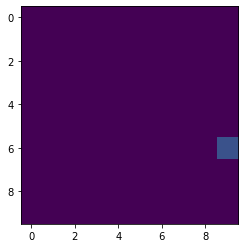

In [314]:
# init CA
ca = CA(grid_size, cancer_reproduction, death_rate, conversion_rates, dead_cell_removal_rate)
ca.initialize_grid(num_steps)
ca.print_params()
for step in range(num_steps):
    grid = ca.update(step)
#     print(np.count_nonzero(grid==1))
    observe(grid)
    display.display(plt.gcf())
    display.clear_output(wait=True)
    sleep(0.025)
